In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from scipy.linalg import lstsq
import math

In [2]:
from math import pi
import cv2

""" Utility Functions """

def load_image(img_path, shape=None):
    img = cv2.imread(img_path)
    if shape is not None:
        img = cv2.resize(img, shape)
    
    return img

def save_image(img_path, img):
    cv2.imwrite(img_path, img)

def get_rad(theta, phi, gamma):
    return (deg_to_rad(theta),
            deg_to_rad(phi),
            deg_to_rad(gamma))

def get_deg(rtheta, rphi, rgamma):
    return (rad_to_deg(rtheta),
            rad_to_deg(rphi),
            rad_to_deg(rgamma))

def deg_to_rad(deg):
    return deg * pi / 180.0

def rad_to_deg(rad):
    return deg * 180.0 / pi

In [3]:
class ImageTransformer(object):
    """ Perspective transformation class for image
        with shape (height, width, #channels) """

    def __init__(self, image_path, shape):
        self.image_path = image_path
        self.image = load_image(image_path, shape)
 
        self.height = self.image.shape[0]
        self.width = self.image.shape[1]
        self.num_channels = self.image.shape[2]


    """ Wrapper of Rotating a Image """
    def rotate_along_axis(self, theta=0, phi=0, gamma=0, dx=0, dy=0, dz=0):
        
        # Get radius of rotation along 3 axes
        rtheta, rphi, rgamma = get_rad(theta, phi, gamma)
        
        # Get ideal focal length on z axis
        # NOTE: Change this section to other axis if needed
        d = np.sqrt(self.height**2 + self.width**2)
        self.focal = d / (2 * np.sin(rgamma) if np.sin(rgamma) != 0 else 1)
        dz = self.focal

        # Get projection matrix
        mat = self.get_M(rtheta, rphi, rgamma, dx, dy, dz)
        
        return cv2.warpPerspective(self.image.copy(), mat, (self.width, self.height))


    """ Get Perspective Projection Matrix """
    def get_M(self, theta, phi, gamma, dx, dy, dz):
        
        w = self.width
        h = self.height
        f = self.focal

        # Projection 2D -> 3D matrix
        A1 = np.array([ [1, 0, -w/2],
                        [0, 1, -h/2],
                        [0, 0, 1],
                        [0, 0, 1]])
        
        # Rotation matrices around the X, Y, and Z axis
        RX = np.array([ [1, 0, 0, 0],
                        [0, np.cos(theta), -np.sin(theta), 0],
                        [0, np.sin(theta), np.cos(theta), 0],
                        [0, 0, 0, 1]])
        
        RY = np.array([ [np.cos(phi), 0, -np.sin(phi), 0],
                        [0, 1, 0, 0],
                        [np.sin(phi), 0, np.cos(phi), 0],
                        [0, 0, 0, 1]])
        
        RZ = np.array([ [np.cos(gamma), -np.sin(gamma), 0, 0],
                        [np.sin(gamma), np.cos(gamma), 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]])

        # Composed rotation matrix with (RX, RY, RZ)
        R = np.dot(np.dot(RX, RY), RZ)

        # Translation matrix
        T = np.array([  [1, 0, 0, dx],
                        [0, 1, 0, dy],
                        [0, 0, 1, dz],
                        [0, 0, 0, 1]])

        # Projection 3D -> 2D matrix
        A2 = np.array([ [f, 0, w/2, 0],
                        [0, f, h/2, 0],
                        [0, 0, 1, 0]])

        # Final transformation matrix
        return np.dot(A2, np.dot(T, np.dot(R, A1)))

In [4]:
def Get_Roll_Pitch(color_image, depth_image):
    coordinates = hands.process(color_image).multi_hand_landmarks
    AngleOY = None; AngleOZ = None
    if coordinates:
        cord = []
        for handLms in coordinates:
            for id, lm in enumerate(handLms.landmark):
                h, w, c = color_image.shape
                cx, cy = int(lm.x*w), int(lm.y*h)
                d = None
                if cy >= 0 and cy < 480 and cx >= 0 and cx < 640:
                    d = depth_image[cy, cx]
                cord.append((id, lm.x*w, lm.y*h, d))
            # mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)
        depth_mask = green_landmarks(color_image, cord, depth_image)
        
        new_mask = depth_mask.copy()
        OneD = depth_mask.flatten()
        NoZeros = OneD[OneD != 0]
        fltred = NoZeros.copy()
        NoZeros_sort = NoZeros.copy()
        NoZeros_sort.sort()
        
        test = np.diff(NoZeros_sort)

        try:
            ind = test[test>50][0]
            check = True
        except:
            check = False
        if check:
            where = np.where(test == ind)
            th = NoZeros_sort[where[0][0]+1]
            fltred = NoZeros[NoZeros < th]
            new_mask[new_mask >= th] = 0

        X = np.where(new_mask!=0)[0]
        Y = np.where(new_mask!=0)[1]
        Z = np.array([new_mask[X[i], Y[i]] for i in range(len(X))])

        tmp_A = []
        tmp_b = []
        for i in range(len(X)):
            tmp_A.append([X[i], Y[i], 1])
            tmp_b.append(Z[i])
        b = np.matrix(tmp_b).T
        A = np.matrix(tmp_A)

        fit, residual, rnk, s = lstsq(A, b)
        # OXa1, OXb1, OXc1 = 0, 0, 1
        OYa1, OYb1, OYc1 = 0, 1, 0
        OZa1, OZb1, OZc1 = 1, 0, 0

        a2 = fit[0][0]
        b2 = fit[1][0]
        c2 = 1
        # AngleOX = distance(OXa1,OXb1,OXc1,a2,b2,c2)
        AngleOY = distance(OYa1,OYb1,OYc1,a2,b2,c2)
        AngleOZ = distance(OZa1,OZb1,OZc1,a2,b2,c2)
    return AngleOY, AngleOZ


## Это для маски руки, то есть делаем из 21й точки примерно 2000 используя метод ближайшего соседа
def green_landmarks(mask, coord_last, depth):
    img = mask.copy()
    th = 3
    color = (0,255,0)

    for i in range(4):
        cv2.line(img, (int(coord_last[i][1]), int(coord_last[i][2])), 
                 (int(coord_last[i+1][1]), int(coord_last[i+1][2])), color, th)

    for i in range(5, 8):
        cv2.line(img, (int(coord_last[i][1]), int(coord_last[i][2])), 
                 (int(coord_last[i+1][1]), int(coord_last[i+1][2])), color, th)

    for i in range(9, 12):
        cv2.line(img, (int(coord_last[i][1]), int(coord_last[i][2])), 
                 (int(coord_last[i+1][1]), int(coord_last[i+1][2])), color, th)

    for i in range(13, 16):
        cv2.line(img, (int(coord_last[i][1]), int(coord_last[i][2])), 
                 (int(coord_last[i+1][1]), int(coord_last[i+1][2])), color, th)

    for i in range(17, 20):
        cv2.line(img, (int(coord_last[i][1]), int(coord_last[i][2])), 
                 (int(coord_last[i+1][1]), int(coord_last[i+1][2])), color, th)


    img = cv2.line(img, (int(coord_last[0][1]), int(coord_last[0][2])), 
                   (int(coord_last[5][1]), int(coord_last[5][2])), color, th)
    img = cv2.line(img, (int(coord_last[0][1]), int(coord_last[0][2])), 
                   (int(coord_last[9][1]), int(coord_last[9][2])), color, th)
    img = cv2.line(img, (int(coord_last[0][1]), int(coord_last[0][2])), 
                   (int(coord_last[13][1]), int(coord_last[13][2])), color, th)
    img = cv2.line(img, (int(coord_last[0][1]), int(coord_last[0][2])), 
                   (int(coord_last[17][1]), int(coord_last[17][2])), color, th)

    img = cv2.line(img, (int(coord_last[5][1]), int(coord_last[5][2])), 
                   (int(coord_last[9][1]), int(coord_last[9][2])), color, th)
    img = cv2.line(img, (int(coord_last[9][1]), int(coord_last[9][2])), 
                   (int(coord_last[13][1]), int(coord_last[13][2])), color, th)
    img = cv2.line(img, (int(coord_last[13][1]), int(coord_last[13][2])), 
                   (int(coord_last[17][1]), int(coord_last[17][2])), color, 5)


    depth[np.sum(img == [0,255,0], axis=2) < 3] = 0

    return depth
    
    
## считаем угол плоскости
def distance(a1, b1, c1, a2, b2, c2):
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    return math.degrees(math.acos(d))


def Get_Yaw(color_image, depth_image):
    def FindTheAngle(cord):
        point1 = cord[-2]
        point2 = cord[-1]
        x_values = [point1[1], point2[1]]
        y_values = [point1[2], point2[2]]

        deltaY = y_values[0] - y_values[1]
        deltaX = x_values[0] - x_values[1]

        angleInDegrees = np.arctan(deltaY / deltaX) * 180 / np.pi
        if angleInDegrees < 0: 
            angleInDegrees = 179 + angleInDegrees
        return angleInDegrees


    cord_08, cord_012, cord_016 = [], [], []
    Angle_08, Angle_012,Angle_016 = [], [], []
    num = 0
    
    result = None
    coordinates = hands.process(color_image).multi_hand_landmarks
    if coordinates:
        # cv2.imwrite(f"/home/lena/Desktop/Thesis/dataset/F_B/color/img{num}", color_image)
        for handLms in coordinates:
            for ind, lm in enumerate(handLms.landmark):
                h, w, c = color_image.shape

                cx, cy = int(lm.x*w), int(lm.y*h)

                if ind == 0 or ind == 8:
                    cord_08.append((ind, lm.x*w, lm.y*h))
                if ind == 0 or ind == 12:
                    cord_012.append((ind, lm.x*w, lm.y*h))
                    # print(cord_012)
                if ind == 0 or ind == 16:
                    cord_016.append((ind, lm.x*w, lm.y*h))

            mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)


        # angleInDegrees_08 = FindTheAngle(cord_08)
        # cv2.putText(color_image, str(int(angleInDegrees_08)), (10,70), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 2)
        # Angle_08.append(angleInDegrees_08)

        angleInDegrees_012 = FindTheAngle(cord_012)
        # cv2.putText(color_image, str(int(angleInDegrees_012)), (10,70*2), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 2)
        Angle_012.append(angleInDegrees_012)

        # angleInDegrees_016 = FindTheAngle(cord_016)
        # cv2.putText(color_image, str(int(angleInDegrees_016)), (10,70*3), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 2)
        # Angle_016.append(angleInDegrees_016)

        # f_array = np.array(Angle_08, ndmin=2) 
        # s_array = np.array(Angle_012, ndmin=2) 
        # t_array = np.array(Angle_016,ndmin=2)

        # general = np.concatenate((f_array, s_array, t_array), axis=0)
        # result = np.mean(general, axis=0)
        
    # return mean Angle_08, Angle_012, Angle_016
    return Angle_012

In [5]:
max_num_hands= 1; min_det_conf = 0.1; min_tr_conf= 0.1

mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=max_num_hands, 
                      min_detection_confidence=min_det_conf, 
                      min_tracking_confidence=min_tr_conf) 
mpDraw = mp.solutions.drawing_utils

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# Roll

In [6]:
Roll_list = []
Pith_list = []
Yaw_list = []
   
for an in range(-60, 60):    
    
    roll = an

    if an == 0:
        roll = 1

    color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
    img = color.rotate_along_axis(phi=roll)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(img)
    # plt.show()

    blank = np.ones((1280, 960), "uint16")

    angle = roll * np.pi/180
    angle = np.tan(angle)

    for i in range(960):
        a = (i+1) * angle
        blank[:,i] = a

    # plt.imshow(blank)
    # plt.show()

    Roll, Pith = Get_Roll_Pitch(img, blank)
    Yaw = Get_Yaw(img, blank)
    # print(Roll,Pith,Yaw[0])
    Roll_list.append(Roll-90)
    Pith_list.append(Pith-90)
    Yaw_list.append(Yaw-90)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
plt.figure(figsize=(11,7))

plt.plot(Roll_list, label="Roll",linewidth=3, c="#517f83")
plt.plot(Pith_list, label="Pitch", linewidth=3, c="#9e8d77")
plt.plot(Yaw_list, label="Yaw", linewidth=3, c="#583d34")

plt.title("Correlation of angles when changing by ROLL from 60 to -60 degree", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("Number of iterations", fontsize=20)
plt.ylabel("Angle change", fontsize=20)
plt.tick_params(labelsize=15, width=3)

plt.grid(True)
plt.show()

## STD

In [7]:
linsp = np.linspace(60,-59, 120)
Roll = np.array(Roll_list)
Roll_std = np.sqrt(np.sum((Roll - linsp)**2) / (Roll.shape[0] - 1))
Roll_std

/tmp/ipykernel_339797/3417294393.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  Roll_std = np.sqrt(np.sum((Roll - linsp)**2) / (Roll.shape[0] - 1))


inf

In [8]:
Pith = np.array(Pith_list)

Pith_std = np.sqrt(np.sum((Pith - np.mean(Pith))**2) / (Pith.shape[0] - 1))
Pith_std

/tmp/ipykernel_339797/1764536412.py:3: RuntimeWarning: invalid value encountered in double_scalars
  Pith_std = np.sqrt(np.sum((Pith - np.mean(Pith))**2) / (Pith.shape[0] - 1))


nan

In [9]:
Yaw = np.array(Yaw_list)

Yaw_std = np.sqrt(np.sum((Yaw - np.mean(Yaw))**2) / (Yaw.shape[0] - 1))
Yaw_std

/home/lena/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lena/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-0.0

## Img

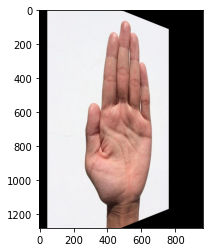

In [10]:
roll = 45


color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
img = color.rotate_along_axis(phi=roll)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [11]:
new_img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3))

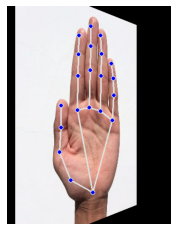

In [12]:
color_image = new_img.copy()
coordinates = hands.process(color_image).multi_hand_landmarks

if coordinates:
    for handLms in coordinates:
        mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)
            
            
plt.imshow(color_image)
plt.axis('off')
plt.show()

# Pith

In [13]:
Roll_from_0_60 = []
Pith_from_0_60 = []
Yaw_from_0_60 = []
for an in range(-60, 60):
    
    pith = an
    
    if an == 0:
        pith = 1

    color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
    img = color.rotate_along_axis(theta=pith)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(img)
    # plt.show()

    blank = np.ones((1280, 960), "uint16")

    angle = pith * np.pi/180
    angle = np.tan(angle)

    for i in range(1280):
        a = (i+1) * angle
        blank[i] = a

    # print(an)
    Roll, Pith = Get_Roll_Pitch(img, blank)
    Yaw = Get_Yaw(img, blank)
    Roll_from_0_60.append(Roll-90)
    Pith_from_0_60.append(Pith-90)
    Yaw_from_0_60.append(Yaw-90)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

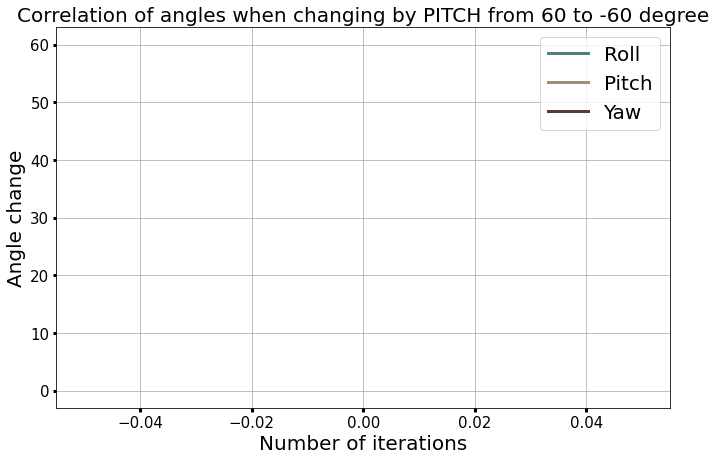

In [14]:
plt.figure(figsize=(11,7))

plt.plot(Roll_from_0_60, label="Roll",linewidth=3, c="#517f83")
plt.plot(Pith_from_0_60, label="Pitch", linewidth=3, c="#9e8d77")
plt.plot(Yaw_from_0_60, label="Yaw", linewidth=3, c="#583d34")

plt.title("Correlation of angles when changing by PITCH from 60 to -60 degree", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("Number of iterations", fontsize=20)
plt.ylabel("Angle change", fontsize=20)
plt.tick_params(labelsize=15, width=3)

plt.grid(True)
plt.show()

## STD

In [15]:
Roll = np.array(Roll_from_0_60)

Roll_std = np.sqrt(np.sum((Roll - np.mean(Roll))**2) / (Roll.shape[0] - 1))
Roll_std

/tmp/ipykernel_339797/3557991392.py:3: RuntimeWarning: invalid value encountered in double_scalars
  Roll_std = np.sqrt(np.sum((Roll - np.mean(Roll))**2) / (Roll.shape[0] - 1))


nan

In [16]:
Yaw = np.array(Yaw_from_0_60)

Yaw_std = np.sqrt(np.sum((Yaw - np.mean(Yaw))**2) / (Yaw.shape[0] - 1))
Yaw_std

-0.0

In [17]:
linsp = np.linspace(60,-59, 120)
Pith = np.array(Pith_from_0_60)
Pith_std = np.sqrt(np.sum((Pith - linsp)**2) / (Pith.shape[0] - 1))
Pith_std

/tmp/ipykernel_339797/2702473807.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  Pith_std = np.sqrt(np.sum((Pith - linsp)**2) / (Pith.shape[0] - 1))


inf

## IMG

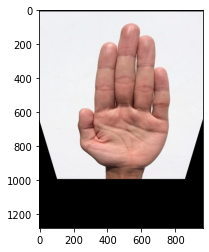

In [18]:
pith = 45

if an == 0:
    pith = 1

color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
img = color.rotate_along_axis(theta=pith)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [19]:
new_img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3))

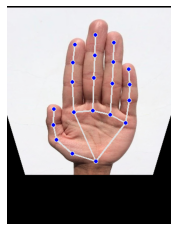

In [20]:
color_image = new_img.copy()
coordinates = hands.process(color_image).multi_hand_landmarks

if coordinates:
    for handLms in coordinates:
        mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)
            
            
plt.imshow(color_image)
plt.axis('off')
plt.show()

# Yaw

In [21]:
Roll_list = []
Pith_list = []
Yaw_list = []
   
for an in range(60, -60, -1):    

    yaw = an

    # if an == 0:
    #     roll = 1

    color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
    img = color.rotate_along_axis(gamma=yaw)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # plt.imshow(img)
    # plt.show()

    blank = np.ones((1280, 960), "uint16")

    #     angle = roll * np.pi/180
    #     angle = np.tan(angle)

    #     for i in range(960):
    #         a = (i+1) * angle
    #         blank[:,i] = a

    # plt.imshow(blank)
    # plt.show()

    Roll, Pith = Get_Roll_Pitch(img, blank)
    Yaw = Get_Yaw(img, blank)
    # print(Roll,Pith,Yaw[0])
    # Roll_list.append(Roll-91)
    Roll_list.append(Roll-90)
    Pith_list.append(Pith-90)
    Yaw_list.append(Yaw[0]-90)

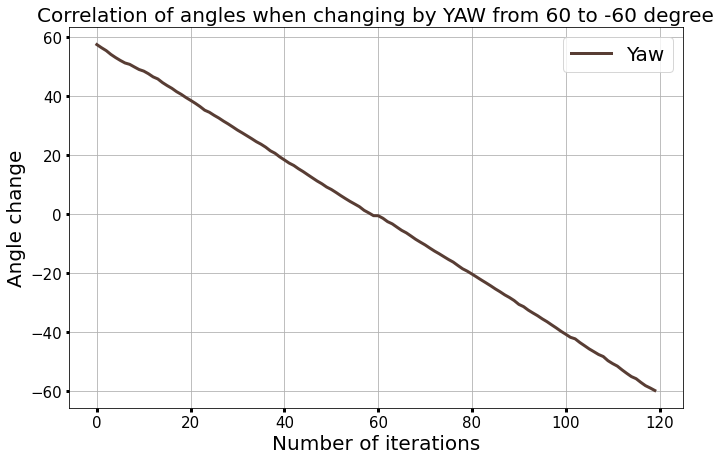

In [35]:
plt.figure(figsize=(11,7))

# plt.plot(Roll_list, label="Roll",linewidth=3, c="#517f83")
# plt.plot(Pith_list, label="Pitch", linewidth=3, c="#9e8d77")
plt.plot(Yaw_list, label="Yaw", linewidth=3, c="#583d34")

plt.title("Correlation of angles when changing by YAW from 60 to -60 degree", fontsize=20)
plt.legend(fontsize=20)
plt.xlabel("Number of iterations", fontsize=20)
plt.ylabel("Angle change", fontsize=20)
plt.tick_params(labelsize=15, width=3)

plt.grid(True)
plt.show()

## STD

In [23]:
linsp = np.linspace(60,-59, 120)
Yaw = np.array(Yaw_list)
Yaw_std = np.sqrt(np.sum((Yaw - linsp)**2) / (Yaw.shape[0] - 1))
Yaw_std

1.3970061014925375

In [24]:
Pith = np.array(Pith_list)

Pith_std = np.sqrt(np.sum((Pith - np.mean(Pith))**2) / (Pith.shape[0] - 1))
Pith_std

5.121463743012434e-14

## IMG

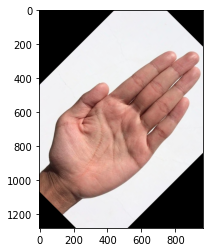

In [25]:
yaw = 45


color = ImageTransformer("./SyntheticDataset/HumanPalm.jpeg", (960, 1280))
img = color.rotate_along_axis(gamma=yaw)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [26]:
new_img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3))

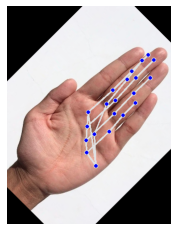

In [27]:
color_image = new_img.copy()
coordinates = hands.process(color_image).multi_hand_landmarks

if coordinates:
    for handLms in coordinates:
        mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)
            
            
plt.imshow(color_image)
plt.axis('off')
plt.show()

# 1 Test

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
from RobotMovement.utils.orientation.OrientEstimation import OrientEstimation

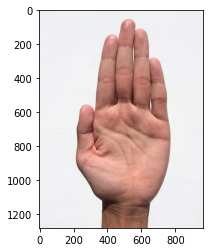

In [29]:
img = cv2.imread("./SyntheticDataset/HumanPalm.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

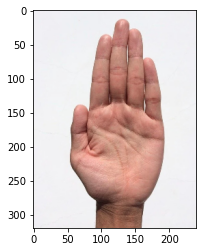

In [30]:
new_img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4))

plt.imshow(new_img)
plt.show()

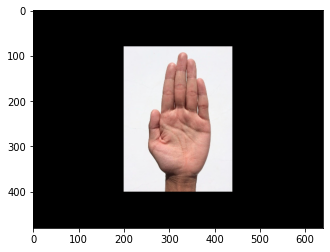

In [31]:
blank = np.zeros((480,640,3), "uint8")

yoff = round((640-240)/2)
xoff = round((480-320)/2)

blank[xoff:xoff+320,yoff:yoff+240, :] = new_img

plt.imshow(blank)
plt.show()

In [32]:
max_num_hands= 1; min_det_conf = 0.1; min_tr_conf= 0.1

mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=max_num_hands, 
                      min_detection_confidence=min_det_conf, 
                      min_tracking_confidence=min_tr_conf) 
mpDraw = mp.solutions.drawing_utils

color_image = blank.copy()
coordinates = hands.process(color_image).multi_hand_landmarks

if coordinates:
    for handLms in coordinates:
         mpDraw.draw_landmarks(color_image, handLms, mpHands.HAND_CONNECTIONS)

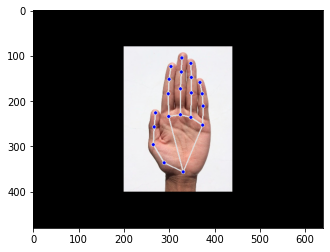

In [33]:
plt.imshow(color_image)
plt.show()

In [34]:
depth_image = np.ones((480,640),"uint16")